In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2
from Energy.Models.Model4_population import model4_population
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3
from Energy.Models.Model5 import model5
from Energy.Models.Model4_holidays_2 import model4_holidays_2
from Energy.Models.Model4_sunhours import model4_sunhours
# import importlib
# importlib.reload(Energy.Models)

In [3]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

100%|██████████| 266/266 [00:57<00:00,  4.59it/s]

                     Netzlast_Gesamt
date_time                           
2024-01-22 01:00:00         48962.50
2024-01-22 02:00:00         48157.75
2024-01-22 03:00:00         48287.75
2024-01-22 04:00:00         49635.00
2024-01-22 05:00:00         53793.25
2024-01-22 06:00:00         61285.75
2024-01-22 07:00:00         67834.75
2024-01-22 08:00:00         71177.75
2024-01-22 09:00:00         71795.25
2024-01-22 10:00:00         36243.00


In [4]:
df = get_energy_data()
df = prepare_data(df)

In [5]:
from Energy.Models.Model5 import add_dummies

df = df.rename(columns={"gesamt": "energy_consumption"})
df = add_dummies(df)

In [8]:
df.dtypes

energy_consumption              float64
winter                            int64
high_consumption_time             int64
medium_high_consumption_time      int64
transition_time                   int64
weekend_day                       int64
holiday                           int64
population                      float64
sun_hours                       float64
dtype: object

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import numpy as np

In [15]:
df.columns

Index(['energy_consumption', 'winter', 'high_consumption_time',
       'medium_high_consumption_time', 'transition_time', 'weekend_day',
       'holiday', 'population', 'sun_hours'],
      dtype='object')

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(df.select_dtypes(include=numerics).columns)
df = df[numerical_vars]
df.shape

(44531, 9)

In [17]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['energy_consumption'], axis=1),
    df['energy_consumption'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((31171, 8), (13360, 8))

In [18]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [83]:
numvars = pd.DataFrame(columns=['numVariables'])
numvar_old = 8
for alpha in np.arange(0.0,5.0,0.01):
    sel_ = SelectFromModel(Lasso(alpha=alpha))
    sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
    numvar = sum(sel_.get_support())
    if numvar_old != numvar:
        # print(sel_.get_support())
        print(f'alpha {alpha}: {np.asarray(numerical_vars[1:])[sel_.get_support() == False]}')
    numvar_old = numvar
    numvars.loc[alpha] = numvar 
    # numvars = numvars.append({'alpha':alpha,'numvars':numvar})
numvars

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/sklearn/base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.188e+05, tolerance: 2.989e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridg

alpha 0.88: ['transition_time']
alpha 1.42: ['transition_time' 'population']
alpha 1.96: ['transition_time' 'holiday' 'population']
alpha 2.05: ['transition_time' 'holiday' 'population' 'sun_hours']
alpha 2.64: ['medium_high_consumption_time' 'transition_time' 'holiday' 'population'
 'sun_hours']
alpha 2.93: ['winter' 'medium_high_consumption_time' 'transition_time' 'holiday'
 'population' 'sun_hours']
alpha 4.0: ['winter' 'high_consumption_time' 'medium_high_consumption_time'
 'transition_time' 'holiday' 'population' 'sun_hours']
alpha 4.37: ['winter' 'high_consumption_time' 'medium_high_consumption_time'
 'transition_time' 'weekend_day' 'holiday' 'population' 'sun_hours']


,numVariables
0.00,8
0.01,8
0.02,8
0.03,8
0.04,8
...,...
4.95,0
4.96,0
4.97,0
4.98,0


In [77]:
# numerical_vars
# np.asarray(numerical_vars[1:])[sel_.get_support()]

array([False, False, False, False, False, False, False, False])

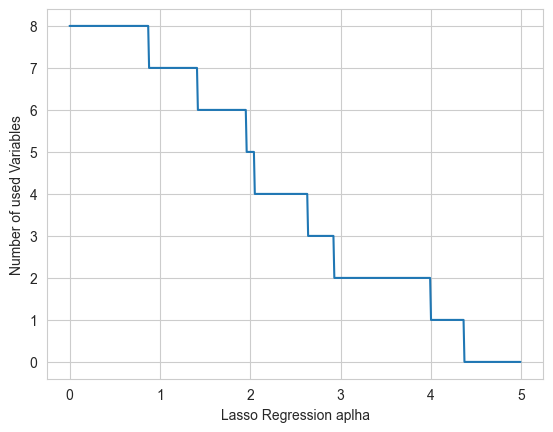

In [65]:
import matplotlib.pyplot as plt

plt.plot(numvars)
plt.xlabel('Lasso Regression aplha')
plt.ylabel('Number of used Variables')
plt.savefig('./Plots/Lasso.png')
plt.show()